In [1]:
def get_gene_names(contig):
    c = data.genes(contig=contig)
    gene_names = set([g.gene_name for g in c])
    return gene_names

In [2]:
def check_genes(chrom_gene_names, important_genes):
    hits = []
    for g in important_genes:
        if g in chrom_gene_names:
            hits.append(g)
    print(len(hits), '/ %s important genes found.' % (str(len(important_genes))))
    genes = []
    for g in hits:
        genes.append(data.genes_by_name(g))
    return genes

In [3]:
def calc_prop(prop):
    for key in prop:
        print(key, sum(prop[key]))

In [4]:
def read_data(f, num_clones):
    bins = dict()
    cloneprop = dict()
    for i in range(num_clones):
        if i == 0:
            cloneprop['norm'] = []
        else:
            cloneprop['c%s' % str(i)]  = []
    with open(f, "r") as r: 
        lines = r.readlines()
        print(lines[0])
        for line in lines[1:]: 
            elems = line.split()
            chrm, start, end, sample = elems[:4]
            tup = []
            #print(elems[11:])
            for i, x in enumerate(elems[11:]): 
                if i == 1:
                    cloneprop['norm'].append(float(x))
                elif i % 2 == 1:
                    cloneprop['c%s' % str(i // 2)].append(float(x))
                if i % 2 == 0:
                    tup.append(x)

            if sample not in bins.keys():
                bins[sample] = dict()
            if chrm not in bins[sample]:
                bins[sample][chrm] = dict()
                
            bins[sample][chrm][start] = [(start, end), tuple(tup)]
    
    return bins, cloneprop

In [5]:
def find_ref(bins):
    # find what the reference WGD is
    counts = dict()
    for sample in bins:
        for chrm in bins[sample]:
            for bin_s in bins[sample][chrm]:
                norm = bins[sample][chrm][bin_s][1][0]
                if norm not in counts:
                    counts[norm] = 0
                counts[norm] += 1
    return counts

In [6]:
def find_sum(s):
    a, b = s.split('|')
    return int(a) + int(b)

In [7]:
def calc_overlap(bin_s, bin_e, gene_s, gene_e):
    return min(bin_e, gene_e) - max(bin_s, gene_s)

In [8]:
def run_overlapping_bindict(important_gene_dict, bins):
    overlapping_bindict = dict()
    for chrm in important_gene_dict.keys():
        overlapping_bindict[chrm] = dict()
        for gene in important_gene_dict[chrm]: 
            print("Processing gene %s" % gene[0], (gene[1], gene[2]))

            c, s, e = 'chr%s' % str(chrm), gene[1], gene[2]
            overlapping_bins = [set(), 0] 
            for sample in bins.keys():

                for bin_s in bins[sample][c]:
                    bin_s, bin_e = bins[sample][c][bin_s][0]
                    bin_s, bin_e = int(bin_s), int(bin_e)

                    o = calc_overlap(bin_s, bin_e, s, e)
                    if o > 0:
                        print(o, (s, e), (bin_s, bin_e))
                        if o > overlapping_bins[1]:
                            print("Updating overlapping_bins because", o, ">", overlapping_bins[1])
                            overlapping_bins[0] = (bin_s, bin_e)
                            overlapping_bins[1] = o

            print(overlapping_bins)
            if overlapping_bins[0]:
                overlapping_bindict[chrm][gene] = overlapping_bins[0]
    return overlapping_bindict

In [9]:
def run_heatmap_dict(overlapping_bindict, numclones, bins): 
    heatmap_dict = dict()

    # figure out total sum counts at each of these segments
    for chrm in overlapping_bindict:
        for gene_info in overlapping_bindict[chrm]:
            gene_name, gene_s, gene_e = gene_info
            # print(overlapping_bindict[chrm][gene_info])
            bin_s, bin_e = overlapping_bindict[chrm][gene_info]
            for sample in bins.keys():
                if sample not in heatmap_dict:
                    heatmap_dict[sample] = dict()
                if gene_name not in heatmap_dict[sample]:
                    heatmap_dict[sample][gene_name] = dict()
                
                cn_norm = bins[sample]['chr%s' % str(chrm)][str(bin_s)][1][0]
                
                cn_list, cn_allele_list, cn_loh_list = [], [], []
                for i in range(1, numclones):
                    cn = bins[sample]['chr%s' % str(chrm)][str(bin_s)][1][i]
                    cn_sum = find_sum(cn)
                    cn_allele = cn.split('|')
                    cn_loh = True if int(cn_allele[0]) == 0 or int(cn_allele[1]) == 0 else False 
                    
                    cn_list.append(cn_sum)
                    cn_allele_list.append(cn_allele)
                    cn_loh_list.append(cn_loh)
                    
                heatmap_dict[sample][gene_name]['total_cn'] = cn_list
                heatmap_dict[sample][gene_name]['allele'] = cn_allele_list 
                heatmap_dict[sample][gene_name]['LOH'] = cn_loh_list 

    return heatmap_dict

In [10]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def run_plot_genes(overlapping_bindict, heatmap_dict, patient, numclones):
    if numclones == 2: 
        plot_data = []
    elif numclones > 2:
        plot_data = []
        for i in range(numclones-1):
            plot_data.append([])
    
    genes = list(heatmap_dict[patient])
    groups = dict()

    # create groups
    for chrm in overlapping_bindict:
        groups[chrm] = [] 
        for gene in genes:
            if gene in set([x[0] for x in overlapping_bindict[chrm].keys()]): 
                groups[chrm].append(gene)
    print(groups)

    for gene in genes: 
        cn_sums = heatmap_dict[patient][gene]['total_cn']
        if numclones == 2:
            plot_data.append(cn_sums[0])
        else:
            print("cn_sums", cn_sums)
            for i, x in enumerate(cn_sums):
                plot_data[i].append(x)
    
    if numclones == 2:
        plot_data = np.array([plot_data])
    else:
        plot_data = np.array(plot_data)
    
    print(plot_data)
    
    ylabels = ['Clone %s' % str(i) for i in range(1, numclones)]
    print(ylabels)
    ax = sns.heatmap(plot_data, center=2.0, linewidths=.5, xticklabels=genes, yticklabels=ylabels, cmap="YlGnBu", annot=True, fmt='d')
    for i, gene in enumerate(genes): 
        for j, loh in enumerate(heatmap_dict[patient][gene]['LOH']):
            if loh:
                #print(i, j)
                ax.add_patch(Rectangle((i, j), 1, 1, edgecolor='blue', fill=False, lw=3))

    ax.set_title('%s Edited HATCHet: Total CN' % patient )
    plt.ylabel('Clones')
    plt.xlabel('Genes')
    return genes

In [11]:
def run_plot_allele_specific_genes(heatmap_dict, patient): 

    plot_data = [[], []]
    genes = list(heatmap_dict[sample])
    for gene in genes: 
        cn_sum_c1 = heatmap_dict[sample][gene]['allele']
        plot_data[0].append(int(cn_sum_c1[0][0]))
        plot_data[1].append(int(cn_sum_c1[0][1]))
    plot_data = np.array(plot_data)

    ax = sns.heatmap(plot_data, center=2.0, linewidths=.5, cmap="YlGnBu", xticklabels=genes, yticklabels=['Clone 1: A', 'Clone 1: B'], annot=True, fmt='d')
    ax.set_title('%s Edited HATCHet: Allele-Specific CN' % patient)
    for i, gene in enumerate(genes): 
        for j, cns in enumerate(heatmap_dict[sample][gene]['allele']):
            for z, cn in enumerate(cns):
                cn = int(cn)
                if cn < ref:
                    ax.add_patch(Rectangle((i, j*2 + z), 1, 1, edgecolor='blue', fill=False, lw=3))

    plt.ylabel('Allele-Specific Clones')
    plt.xlabel('Genes')

In [12]:
def run_plot_summary(heatmap_dict):
    plot_data = []
    genes = list(heatmap_dict[sample])
    groups = dict()

    # create groups
    for chrm in overlapping_bindict:
        groups[chrm] = [] 
        for gene in genes:
            if gene in set([x[0] for x in overlapping_bindict[chrm].keys()]): 
                groups[chrm].append(gene)
    print(groups)


    for gene in genes: 
        for i, cn in enumerate(heatmap_dict[sample][gene]['total_cn']):
            if cn > ref: 
                plot_data.append(1)
            elif cn == ref:
                plot_data.append(0)
            else:
                plot_data.append(-1)
    plot_data = np.array([plot_data])
    print(list(plot_data))


    ax = sns.heatmap(plot_data, center=0, linewidths=.5, xticklabels=genes, yticklabels=['Clone 1'], cmap="PiYG")
    for i, gene in enumerate(genes): 
        for j, loh in enumerate(heatmap_dict[sample][gene]['LOH']):
            if loh:
                #print(i, j)
                ax.add_patch(Rectangle((i, j), 1, 1, edgecolor='blue', fill=False, lw=3))

    # annotate with chrm
    # https://stackoverflow.com/questions/58854335/how-to-label-y-ticklabels-as-group-category-in-seaborn-clustermap
    #annotate_xranges(groups)

    ax.set_title('%s Edited HATCHet: Total CN' % patient)
    plt.ylabel('Clones')
    plt.xlabel('Genes')


In [13]:
def calc_plot_data(sncell, edited, genes): 
    count_sum = dict()
    count_sum['amps'] = dict()
    count_sum['amps']['amps'] = 0
    count_sum['amps']['neus'] = 0
    count_sum['amps']['dels'] = 0
    count_sum['neus'] = dict()
    count_sum['neus']['amps'] = 0
    count_sum['neus']['neus'] = 0
    count_sum['neus']['dels'] = 0
    count_sum['dels'] = dict()
    count_sum['dels']['amps'] = 0
    count_sum['dels']['neus'] = 0
    count_sum['dels']['dels'] = 0

    correct = []
    incorrect = []
    for clone_idx, d in enumerate(sncell):
        for gene_idx, g in enumerate(sncell[clone_idx]):
            if g == 1:
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['amps']['amps'] += 1
                    correct.append(('amps, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['amps']['neus'] += 1
                    incorrect.append(('amps, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['amps']['dels'] += 1
                    incorrect.append(('amps, dels', genes[gene_idx]))
                else:
                    print("huh?")
            elif g == 0: 
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['neus']['amps'] += 1
                    incorrect.append(('neus, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['neus']['neus'] += 1
                    correct.append(('neus, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['neus']['dels'] += 1
                    incorrect.append(('neus, dels', genes[gene_idx]))
                else:
                    print("huh?")
            elif g == -1:
                if edited[clone_idx][gene_idx] == 1:
                    count_sum['dels']['amps'] += 1
                    incorrect.append(('dels, amps', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == 0:
                    count_sum['dels']['neus'] += 1
                    incorrect.append(('dels, neus', genes[gene_idx]))
                elif edited[clone_idx][gene_idx] == -1:
                    count_sum['dels']['dels'] += 1
                    correct.append(('dels, dels', genes[gene_idx]))
                else:
                    print("huh?")
    print("correct", correct)
    print("incorrect", incorrect)
    plot_data = []
    plot_data = [[count_sum['amps']['amps'], count_sum['amps']['neus'], count_sum['amps']['dels']],
              [count_sum['neus']['amps'], count_sum['neus']['neus'], count_sum['neus']['dels']],
              [count_sum['dels']['amps'], count_sum['dels']['neus'], count_sum['dels']['dels']]
             ]
    return plot_data

In [14]:
def run_plot_heatmap(data, title): 
    cmap = sns.color_palette("flare", as_cmap=True)
    ax = sns.heatmap(data, linewidths=.5, xticklabels=['Amplification', 'Neutral', "Deletion"], yticklabels=['Amplification', 'Neutral', "Deletion"], annot =True, fmt='d', cmap=cmap)
    ax.set_title(title)
    plt.ylabel('Single Cell Classification')
    plt.xlabel('HATCHet Classification')


In [15]:
from pyensembl import EnsemblRelease
data = EnsemblRelease(104)

# Casasent Patient P6

In [16]:
patient = 'P6'

In [17]:
casasent_c2 = ['ERCC3', 'PMS1', 'CREB1']
casasent_c3 = ['MECOM', 'PIK3CA'] # EVI1 = MECOM
casasent_c7 = ['AFDN'] # MLLT4 = AFDN = AF6
casasent_c13 = ['BRCA2', 'RB1', 'ERCC5']
casasent_c15 = ['NUTM1', 'TCF12', 'NTRK3'] # C15orf55 = NUTM1
casasent_c18 = ['MAT11', 'BCL2'] # MAT11 = ?

gene_names_c2 = get_gene_names(2)
gene_names_c3 = get_gene_names(3)
gene_names_c7 = get_gene_names(7)
gene_names_c13 = get_gene_names(13)
gene_names_c15 = get_gene_names(15)
gene_names_c18 = get_gene_names(18)

genes_c2 = check_genes(gene_names_c2, casasent_c2)
genes_c3 = check_genes(gene_names_c3, casasent_c3)
genes_c7 = check_genes(gene_names_c7, casasent_c7)
genes_c13 = check_genes(gene_names_c13, casasent_c13)
genes_c15 = check_genes(gene_names_c15, casasent_c15)
genes_c18 = check_genes(gene_names_c18, casasent_c18)

important_gene_dict = dict()
important_gene_dict[2] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c2]
important_gene_dict[3] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c3]
important_gene_dict[7] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c7]
important_gene_dict[13] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c13]
important_gene_dict[15] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c15]
important_gene_dict[18] = [(g[0].gene_name, g[0].start, g[0].end) for g in genes_c18]


3 / 3 important genes found.
2 / 2 important genes found.
0 / 1 important genes found.
3 / 3 important genes found.
3 / 3 important genes found.
1 / 2 important genes found.


Unedited Hatchet

In [18]:
# for unedited hatchet 

old_hatchet = "/Users/gillianchu/mek/cnaviz/og_hatchet/output_P6/results/best.bbc.ucn"
og_bins, og_prop = read_data(old_hatchet, 4)
print(find_ref(og_bins))
calc_prop(og_prop)

#CHR	START	END	SAMPLE	RD	#SNPS	COV	ALPHA	BETA	BAF	CLUSTER	cn_normal	u_normal	cn_clone1	u_clone1	cn_clone2	u_clone2	cn_clone3	u_clone3

{'1|1': 13332}
norm 2737.046267999789
c1 1273.1186753997767
c2 7056.7342560012075
c3 2265.1041335995365


In [19]:
ref = 2

In [20]:
unedited_overlapping_bindict = run_overlapping_bindict(important_gene_dict, og_bins)
unedited_heatmap_dict = run_heatmap_dict(unedited_overlapping_bindict, 4, og_bins)

Processing gene ERCC3 (127257290, 127294166)
36876 (127257290, 127294166) (127250000, 127500000)
Updating overlapping_bins because 36876 > 0
36876 (127257290, 127294166) (127250000, 127500000)
[(127250000, 127500000), 36876]
Processing gene PMS1 (189784085, 189877629)
93544 (189784085, 189877629) (189750000, 190000000)
Updating overlapping_bins because 93544 > 0
93544 (189784085, 189877629) (189750000, 190000000)
[(189750000, 190000000), 93544]
Processing gene CREB1 (207529737, 207605988)
76251 (207529737, 207605988) (207500000, 207750000)
Updating overlapping_bins because 76251 > 0
76251 (207529737, 207605988) (207500000, 207750000)
[(207500000, 207750000), 76251]
Processing gene MECOM (169083499, 169663775)
163775 (169083499, 169663775) (169500000, 169750000)
Updating overlapping_bins because 163775 > 0
163775 (169083499, 169663775) (169500000, 169750000)
[(169500000, 169750000), 163775]
Processing gene PIK3CA (179148114, 179240093)
91979 (179148114, 179240093) (179000000, 179250000)

Edited Hatchet

In [21]:
# for edited hatchet 
# chosen solution was tetraploid
edited_hatchet = "/Users/gillianchu/mek/cnaviz/og_hatchet/output_HP6_v1/results/results.diploid.n3.bbc.ucn.tsv"
edited_bins, edited_cloneprop = read_data(edited_hatchet, 3)
print(find_ref(edited_bins))
calc_prop(edited_cloneprop)

#CHR	START	END	SAMPLE	RD	#SNPS	COV	ALPHA	BETA	BAF	CLUSTER	cn_normal	u_normal	cn_clone1	u_clone1	cn_clone2	u_clone2

{'1|1': 13272}
norm 3727.580555999798
c1 2127.926304000176
c2 7416.486503998916


In [22]:
ref = 2

In [23]:
edited_overlapping_bindict = run_overlapping_bindict(important_gene_dict, edited_bins)
edited_heatmap_dict = run_heatmap_dict(edited_overlapping_bindict, 2, edited_bins)

Processing gene ERCC3 (127257290, 127294166)
36876 (127257290, 127294166) (127250000, 127500000)
Updating overlapping_bins because 36876 > 0
36876 (127257290, 127294166) (127250000, 127500000)
[(127250000, 127500000), 36876]
Processing gene PMS1 (189784085, 189877629)
93544 (189784085, 189877629) (189750000, 190000000)
Updating overlapping_bins because 93544 > 0
93544 (189784085, 189877629) (189750000, 190000000)
[(189750000, 190000000), 93544]
Processing gene CREB1 (207529737, 207605988)
76251 (207529737, 207605988) (207500000, 207750000)
Updating overlapping_bins because 76251 > 0
76251 (207529737, 207605988) (207500000, 207750000)
[(207500000, 207750000), 76251]
Processing gene MECOM (169083499, 169663775)
163775 (169083499, 169663775) (169500000, 169750000)
Updating overlapping_bins because 163775 > 0
163775 (169083499, 169663775) (169500000, 169750000)
[(169500000, 169750000), 163775]
Processing gene PIK3CA (179148114, 179240093)
91979 (179148114, 179240093) (179000000, 179250000)

# Looking at the Majority Clones

{2: ['ERCC3', 'PMS1', 'CREB1'], 3: ['MECOM', 'PIK3CA'], 7: [], 13: ['BRCA2', 'RB1'], 15: ['NUTM1', 'NTRK3'], 18: ['BCL2']}
cn_sums [1, 1, 0]
cn_sums [2, 1, 1]
cn_sums [2, 1, 1]
cn_sums [3, 2, 2]
cn_sums [3, 2, 2]
cn_sums [5, 1, 2]
cn_sums [3, 2, 1]
cn_sums [0, 1, 0]
cn_sums [0, 1, 0]
cn_sums [1, 1, 0]
[[1 2 2 3 3 5 3 0 0 1]
 [1 1 1 2 2 1 2 1 1 1]
 [0 1 1 2 2 2 1 0 0 0]]
['Clone 1', 'Clone 2', 'Clone 3']


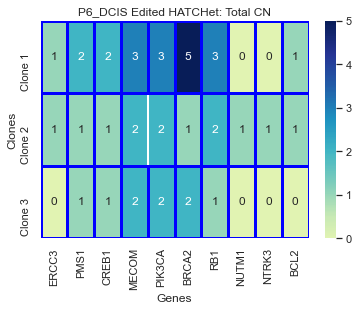

In [24]:
og_dcis_genes = run_plot_genes(unedited_overlapping_bindict, unedited_heatmap_dict, "P6_DCIS", 4)

{2: ['ERCC3', 'PMS1', 'CREB1'], 3: ['MECOM', 'PIK3CA'], 7: [], 13: ['BRCA2', 'RB1'], 15: ['NUTM1', 'NTRK3'], 18: ['BCL2']}
cn_sums [1, 1, 0]
cn_sums [2, 1, 1]
cn_sums [2, 1, 1]
cn_sums [3, 2, 2]
cn_sums [3, 2, 2]
cn_sums [5, 1, 2]
cn_sums [3, 2, 1]
cn_sums [0, 1, 0]
cn_sums [0, 1, 0]
cn_sums [1, 1, 0]
[[1 2 2 3 3 5 3 0 0 1]
 [1 1 1 2 2 1 2 1 1 1]
 [0 1 1 2 2 2 1 0 0 0]]
['Clone 1', 'Clone 2', 'Clone 3']


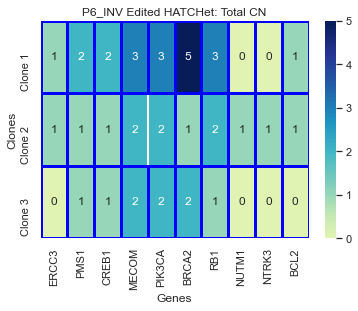

In [25]:
og_inv_genes = run_plot_genes(unedited_overlapping_bindict, unedited_heatmap_dict, "P6_INV", 4)

{2: ['ERCC3', 'PMS1', 'CREB1'], 3: ['MECOM', 'PIK3CA'], 7: [], 13: ['BRCA2', 'RB1'], 15: ['NUTM1', 'NTRK3'], 18: ['BCL2']}
[[1 3 3 2 2 3 3 0 1 1]]
['Clone 1']


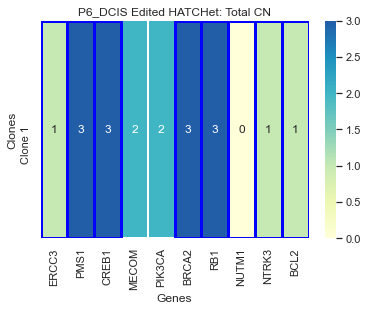

In [26]:
edit_dcis_genes = run_plot_genes(edited_overlapping_bindict, edited_heatmap_dict, "P6_DCIS", 2)

{2: ['ERCC3', 'PMS1', 'CREB1'], 3: ['MECOM', 'PIK3CA'], 7: [], 13: ['BRCA2', 'RB1'], 15: ['NUTM1', 'NTRK3'], 18: ['BCL2']}
[[1 3 3 2 2 3 3 0 1 1]]
['Clone 1']


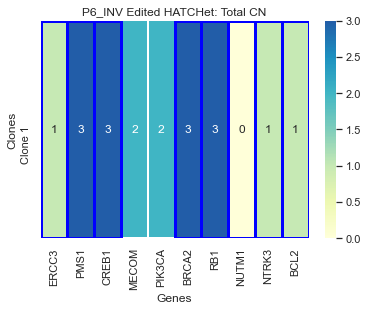

In [27]:
edit_inv_genes = run_plot_genes(edited_overlapping_bindict, edited_heatmap_dict, "P6_INV", 2)

In [37]:
sample = 'P6_INV'

sncell = [[-1, 2, 2, 1, 1, 2, 2, -1, -1, -1]]
edited = [[-1,  2,  2,  1,  1,  1,  1, -1, -1, -1]]
original = [[-1, -1, -1,  1,  1,  2,  2, -1, -1, -1]]  # 0 is neutral and both is 2


In [38]:
edited_plot_data = calc_plot_data(sncell, edited, edit_inv_genes)
original_plot_data = calc_plot_data(sncell, original, og_inv_genes)

correct [('dels, dels', 'ERCC3'), ('amps, amps', 'MECOM'), ('amps, amps', 'PIK3CA'), ('dels, dels', 'NUTM1'), ('dels, dels', 'NTRK3'), ('dels, dels', 'BCL2')]
incorrect []
correct [('dels, dels', 'ERCC3'), ('amps, amps', 'MECOM'), ('amps, amps', 'PIK3CA'), ('dels, dels', 'NUTM1'), ('dels, dels', 'NTRK3'), ('dels, dels', 'BCL2')]
incorrect []


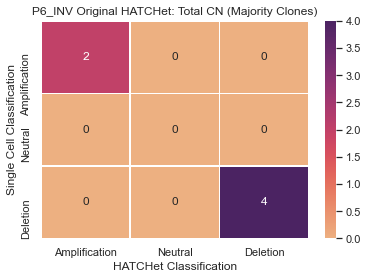

In [39]:
title = "%s Original HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(original_plot_data, title)

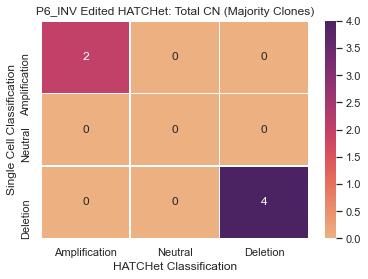

In [40]:
title = "%s Edited HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(edited_plot_data, title)

In [41]:
# write to file
f = "/Users/gillianchu/mek/cnaviz/genes/summary/P6_INV_hatchet.txt"
with open(f, "w+") as w:
    w.write(str(original_plot_data) + "\n")
    w.write(str(edited_plot_data) + "\n")

In [42]:
sample = 'P6_DCIS'

sncell = [[-1, 1,  1,  1, 1, 0,  0,   -1, -1, -1]] # dark purple
edited = [[-1, -1, -1,  1,  1,  0,  0, -1, -1, -1]] # clone c2
original = [[-1, -1, -1,  0,  0, -1,  0, -1, -1, -1]] # clone c2

In [43]:
edited_plot_data = calc_plot_data(sncell, edited, edit_dcis_genes)
original_plot_data = calc_plot_data(sncell, original, og_dcis_genes)

correct [('dels, dels', 'ERCC3'), ('amps, amps', 'MECOM'), ('amps, amps', 'PIK3CA'), ('neus, neus', 'BRCA2'), ('neus, neus', 'RB1'), ('dels, dels', 'NUTM1'), ('dels, dels', 'NTRK3'), ('dels, dels', 'BCL2')]
incorrect [('amps, dels', 'PMS1'), ('amps, dels', 'CREB1')]
correct [('dels, dels', 'ERCC3'), ('neus, neus', 'RB1'), ('dels, dels', 'NUTM1'), ('dels, dels', 'NTRK3'), ('dels, dels', 'BCL2')]
incorrect [('amps, dels', 'PMS1'), ('amps, dels', 'CREB1'), ('amps, neus', 'MECOM'), ('amps, neus', 'PIK3CA'), ('neus, dels', 'BRCA2')]


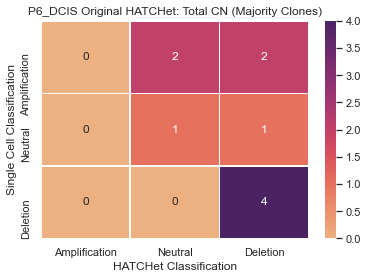

In [44]:
title = "%s Original HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(original_plot_data, title)

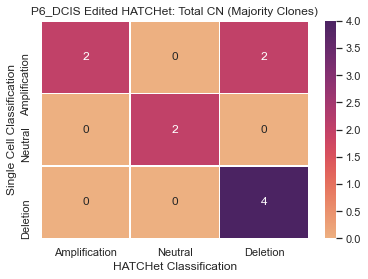

In [45]:
title = "%s Edited HATCHet: Total CN (Majority Clones)" % sample
run_plot_heatmap(edited_plot_data, title)

In [46]:
# write to file
f = "/Users/gillianchu/mek/cnaviz/genes/summary/P6_DCIS_hatchet.txt"
with open(f, "w+") as w:
    w.write(str(original_plot_data) + "\n")
    w.write(str(edited_plot_data) + "\n")